# Instrumental Variables Part 1: Basics

A great introduction to IV methods can be found at ([Lousdal, 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5776781/)). Note that IV methods are predominantely used in Econometrics, but the above article is from an epidemiologist's point of view. There's no deeper meaning to that, it was just an article that helped me a lot.

Let's start with a familiar DAG:

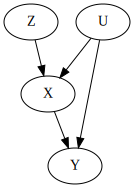

In [8]:
import graphviz as gr

g  = gr.Digraph()

# nodes
g.node('Z', 'Z');g.node('X', 'X');g.node('U','U');g.node('Y', 'Y')

# edges
g.edge('Z', 'X');g.edge('X', 'Y');g.edge('U','Y');g.edge('U','X')

# output
g

Let:
- $X\sim\text{Bernoulli}\left(p=\frac{Z+0.5+U}{3}\right)$: treatment
- $Y=2X+4U+\epsilon$: outcome
- $U\sim\text{Bernoulli}(p=0.5)$: confounder (assume there is only one. Or if it helps - assume that all confounders have been collected into this variable)
- $Z\sim\text{Bernoulli}(p=0.5)$: an instrument, which we discuss shortly

We know from confounder-control literature that one way to derive a causal effect of $X$ on $Y$ is to run a regression of `Y~X+U`, where in the case of U not being an effect modifier, can be interpreted as a marginal effect. We can quickly demonstrate this below.

First, we'll make a function that lets us simulate data and also allow us to change how much influence $Z$ has on $X$, a feature we will utilize later.

In [9]:
import numpy as np
import pandas as pd

def simulate(n, Z_influence=0.5):
  Z = np.random.binomial(1, 0.5, n)
  U = np.random.binomial(1, 0.5, n)
  X = np.random.binomial(1, (Z_influence*Z+(1-Z_influence)*((U+0.5)/2)), n) # parameter p of X is a weighted average of 0.5 and Z
  Y = 2*X + 4*U + np.random.normal(0,1)
  return pd.DataFrame({'Z':Z,'U':U,'X':X,'Y':Y})

df = simulate(20000)
df.head(3)

,Z,U,X,Y
0,0,0,0,2.162857
1,1,1,1,8.162857
2,1,0,0,2.162857


Now, let's run the model twice: once with our confounder $U$ and once without

In [10]:
import statsmodels.formula.api as smf

model = smf.ols(formula="Y ~ X + U", data=df).fit()
print('Running: Y~X+U')
print(model.params)
print('----------------------')
model = smf.ols(formula="Y ~ X", data=df).fit()
print('Running: Y~X')
print(model.params)

Running: Y~X+U
Intercept    2.162857
X            2.000000
U            4.000000
dtype: float64
----------------------
Running: Y~X
Intercept    3.689968
X            2.967431
dtype: float64


We see that omitting our confounder from the regression will output a biased coefficient of our treatment $X$. In the case where the data for $U$ is unavailable or the list of confounders you've gathered is not convincing to you or the audience, we may need to consider other methods.

The alternative method we discuss is instrumental variable methods. It promises that (in the DAG) a variable like $Z$ exists, we don't need to know $U$.

There's a lot of parts to this, but let's first discuss what it means to be an instrument. There are 3 basic assumptions (and more, which we discuss in a bit):
1. **Relevance**: Instrument $Z$ affects treatment $X$ (the stronger this relation, the better in terms of standard error)
2. **Exclusion-Restriction**: $Z$ affects outcome $Y$ only through $X$
3. **Exchangeability**: No confounding for the effect of $Z$ on $Y$

We see that in our DAG above, all 3 of these conditions are fulfilled.

For an dichotomous treatment and instrument, we can extract the point estimate with the following formula:

$$\frac{E[Y|Z=1]-E[Y|Z=0]}{E[X|Z=1]-E[X|Z=0]}$$

In [11]:
numerator = np.mean(df.loc[df.Z==1,'Y']) - np.mean(df.loc[df.Z==0,'Y'])
denominator = np.mean(df.loc[df.Z==1,'X']) - np.mean(df.loc[df.Z==0,'X'])
print(numerator/denominator)

1.8974023628371461


We were able to pretty much get the right treatment effect. You'll notice that it actually isn't converging to the correct treatment effect as fast as you would expect though. We discuss that later.

More commonly, we use 2SLS Regression (Two-Stage Least Squares Regression) so that we can get the standard errors, which we do below using an R package called [ivreg](https://cran.r-project.org/web/packages/ivreg/vignettes/ivreg.html)



In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items # needed to use this as of 5/1/24 for rpy2
import numpy as np

In [3]:
# Load up R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [6]:
%%R
#install.packages('ivreg') # takes about 6minutes
library('ivreg')

In [16]:
%%R -i df
# Run IV Regression
summary(ivreg(Y ~ X | Z, data=df))


Call:
ivreg(formula = Y ~ X | Z, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-2.066 -2.066  1.934  2.036  2.036 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.22916    0.03206  131.90   <2e-16 ***
X            1.89740    0.05702   33.28   <2e-16 ***

Diagnostic tests:
                   df1   df2 statistic p-value    
Weak instruments     1 19998    6641.5  <2e-16 ***
Wu-Hausman           1 19997     517.8  <2e-16 ***
Sargan               0    NA        NA      NA    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.013 on 19998 degrees of freedom
Multiple R-Squared: 0.3209,	Adjusted R-squared: 0.3209 
Wald test:  1107 on 1 and 19998 DF,  p-value: < 2.2e-16 



We get the same answer.

Earlier, we added a parameter in `simulate()` to allow for modifying the influence of the instrument on the treatment. This is so show below that the weaker the instrument, the more difficult the inference:

In [34]:
def iv_estimate(df):
  numerator = np.mean(df.loc[df.Z==1,'Y']) - np.mean(df.loc[df.Z==0,'Y'])
  denominator = np.mean(df.loc[df.Z==1,'X']) - np.mean(df.loc[df.Z==0,'X'])
  return numerator/denominator

z_ratio = np.arange(0.1, 1, 0.005)
estimates = []
for i in z_ratio:
  estimates.append(iv_estimate(simulate(n=10000, Z_influence=i)))

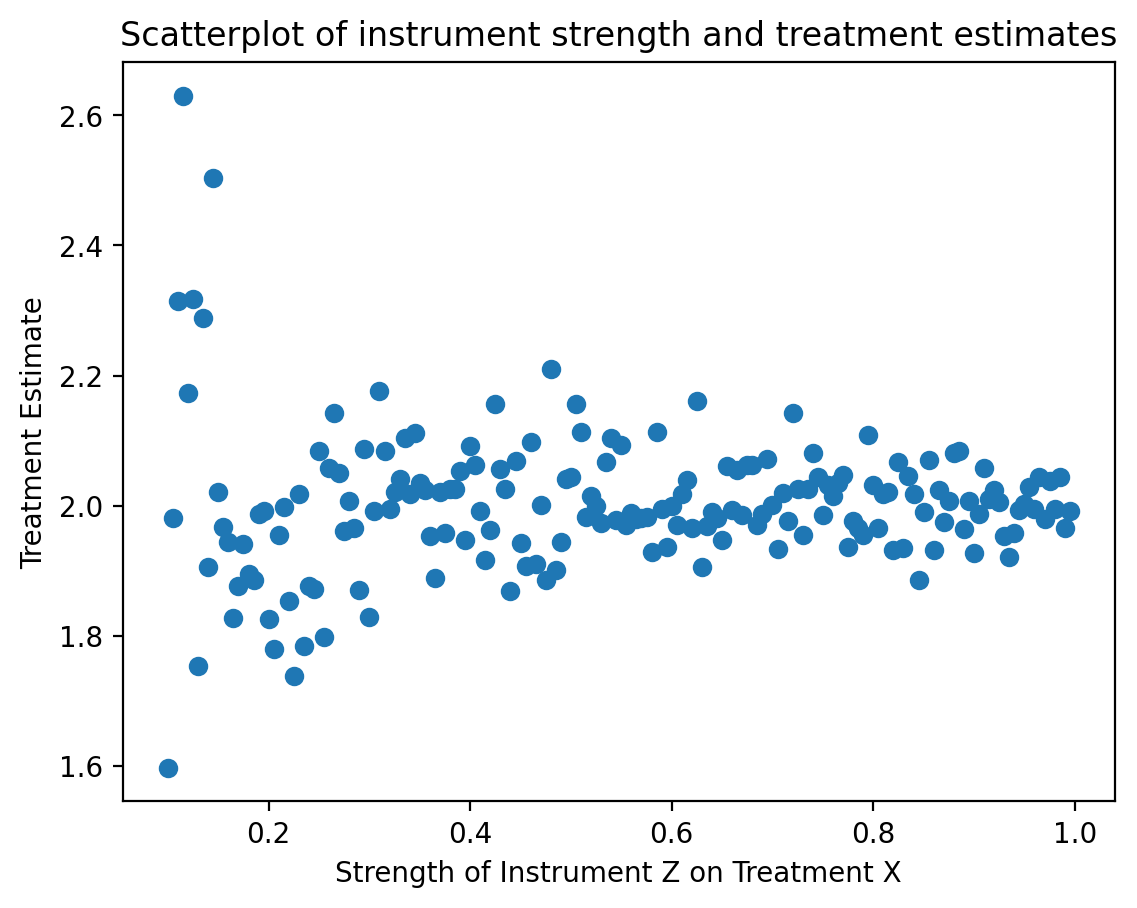

In [35]:
import matplotlib.pyplot as plt
plt.scatter(z_ratio, estimates)
plt.xlabel('Strength of Instrument Z on Treatment X')
plt.ylabel('Treatment Estimate')
plt.title('Scatterplot of instrument strength and treatment estimates')
plt.show()

We can see that when we have a weak instrument, the estimates fluctuate heavily (and thus lack reliability).